![](https://pbs.twimg.com/profile_images/789117657714831361/zGfknUu8_400x400.jpg)

## **1. Loading the dataset and libraries**
- overview
- dataset 확인

In [1]:
# package
import numpy as np 
import pandas as pd 
import os
import json
from pandas.io.json import json_normalize
import ast
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook
from scipy.stats import skew, boxcox
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from mpl_toolkits.mplot3d import Axes3D
import ast
import re
import yaml
import json
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import eli5
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import warnings  
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
import xgboost as xgb

In [3]:
# method
def date_features(df):
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
    # 연도 끝 두자리수만 있기 때문에 앞에 19/20 붙이기
    df.loc[ (train['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (train['release_year'] > 19) & (df['release_year'] < 100), "release_year"] += 1900
    return df

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [4]:
# Loading dataset
train = pd.read_csv('C:/Users/domin/Desktop/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('C:/Users/domin/Desktop/tmdb-box-office-prediction/test.csv')
sam_sub = pd.read_csv('C:/Users/domin/Desktop/tmdb-box-office-prediction/sample_submission.csv')

print( "train dataset:", train.shape,"\n","test dataset: ",test.shape,"\n","sample_submission dataset:", sam_sub .shape)

train dataset: (3000, 23) 
 test dataset:  (4398, 22) 
 sample_submission dataset: (4398, 2)


In [5]:
# dataset 살펴보기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

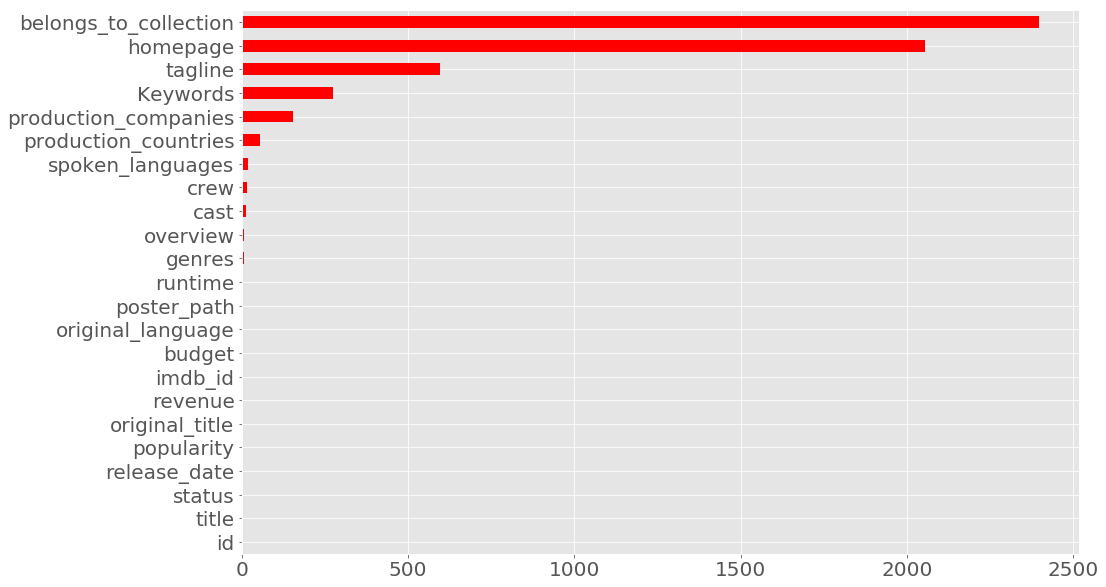

In [6]:
# 결측치 확인

fig = plt.figure(figsize=(15, 10))
train.isna().sum().sort_values(ascending=True).plot(kind='barh',colors='Red', fontsize=20)

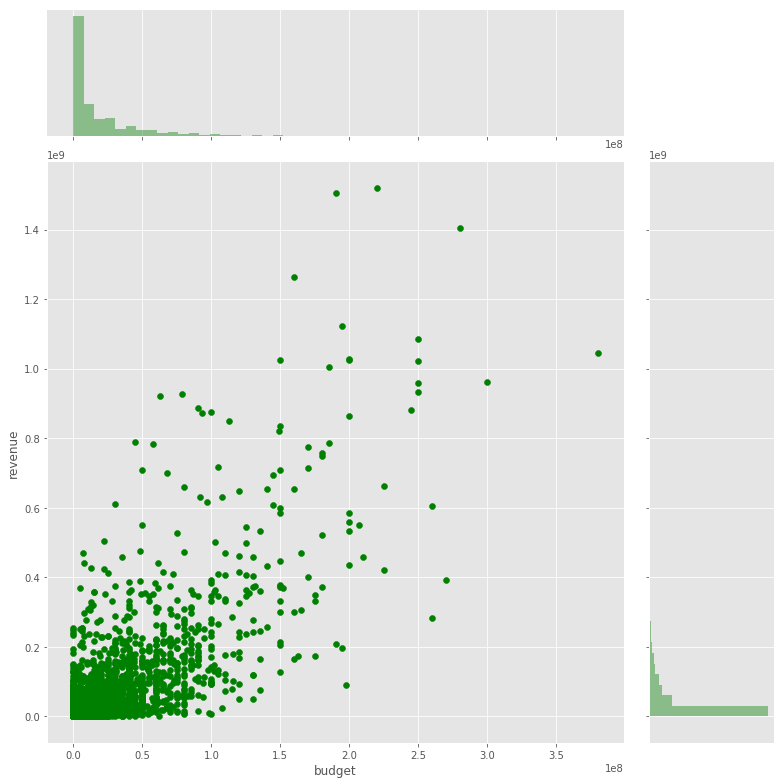

In [7]:
# 예산과 수익은 연관이 많음.

sns.jointplot(x="budget", y="revenue", data=train, height=11, ratio=4, color="g")
plt.show()

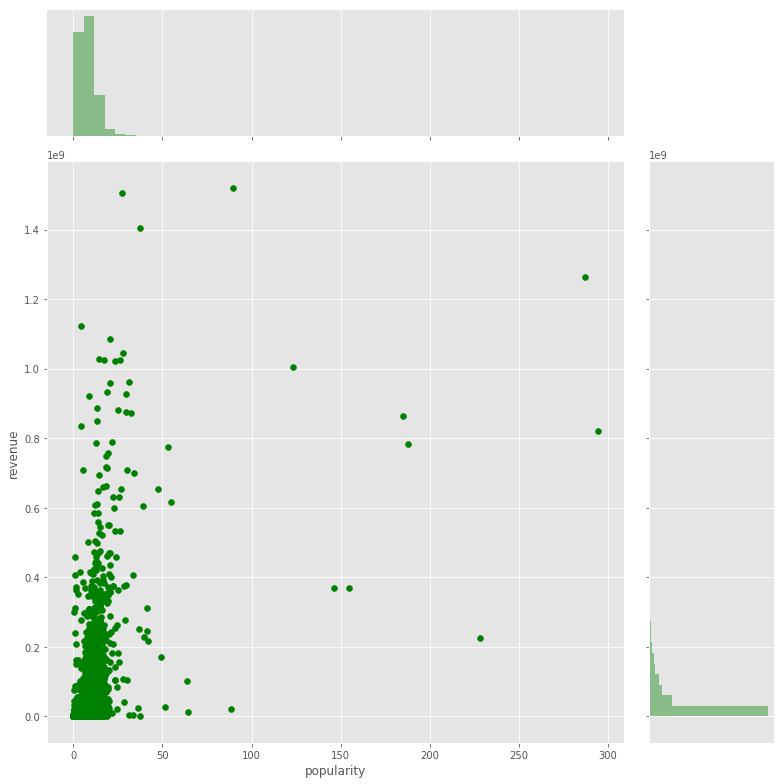

In [8]:
# 인기도와 수익은 연관이 적음.
sns.jointplot(x="popularity", y="revenue", data=train, height=11, ratio=4, color="g")
plt.show()

In [9]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


# 2.1 **Data Pre-processing & EDA**

## date_features 

In [10]:
train = date_features(train)
test = date_features(test)

## 범주형 변수 변환

## **Json Format Columns to Dictionary Format**
<br>

In order to clean up the Json format columns, I am going to convert these columns to the dictionary format and analyze each column.

In [11]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

train = text_to_dict(train)
test = text_to_dict(test)

## **Belong_to collection**

In [12]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

## **Genres**
<br>
Many genres of movies are drama and comedy in the train data. I am going to conduct text analysis on movie titles by genre and revenue comparison over years by genres.

In [13]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

## **production_companies**

In [14]:
train['num_production_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_production_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

## **production_countries**

In [15]:
train['num_production_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_production_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')


## **Cast**

In [16]:
# list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

## **Crew**

In [17]:
# list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
train['all_crew'] = train['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
test['all_crew'] = test['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

## **spoken_languages**

In [18]:
# list_of_spokenlanguage_names = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_spoken_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_spoken_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

test['num_spoken_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_spoken_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

## **keyword**

In [19]:
# list_of_Keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

In [20]:
# category
cat_features = ['all_production_companies',
'all_production_countries',
'all_genres',                
'all_cast',
'all_crew',
'all_spoken_languages',
'all_Keywords']
 
for i in enumerate (cat_features) :
    ca = i[1]
    train[ca] = train[ca].astype('category')
    test[ca] = test[ca].astype('category')

## **Missing data**
<br>

## **homepage**
- 유/무

In [21]:
train['has_homepage'] = 1
train.loc[pd.isnull(train['homepage']) ,"has_homepage"] = 0
test['has_homepage'] = 1
test.loc[pd.isnull(test['homepage']) ,"has_homepage"] = 0

## **tagline**
- 유/무

In [22]:
train['isTaglineNA'] = 0
train.loc[pd.isnull(train['tagline']) ,"isTaglineNA"] = 1
test['isTaglineNA'] = 0
test.loc[pd.isnull(test['tagline']) ,"isTaglineNA"] = 1

## **data 조작**

## **original_languages**

In [23]:
train['isOriginalLanguageEng'] = 0
test['isOriginalLanguageEng'] = 0

train.loc[train['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
test.loc[test['original_language'] == "en" ,"isOriginalLanguageEng"] = 1

## **spoken_languages**

In [24]:
train['isSpokenLanguageEng'] = 0
train.loc[train['all_spoken_languages'] == "English" ,"isSpokenLanguageEng"] = 1
test['isSpokenLanguageEng'] = 0
test.loc[test['all_spoken_languages'] == "English" ,"isSpokenLanguageEng"] = 1

## **original, title**

In [25]:
train['isTitleDifferent'] = 1
train.loc[ train['original_title'] == train['title'] ,"isTitleDifferent"] = 0
test['isTitleDifferent'] = 1
test.loc[ test['original_title'] == test['title'] ,"isTitleDifferent"] = 0

## **drop columns**

In [26]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_month,release_day,release_year,collection_name,has_collection,num_genres,all_genres,num_production_companies,all_production_companies,num_production_countries,all_production_countries,num_cast,all_cast,num_crew,all_crew,num_spoken_languages,all_spoken_languages,num_Keywords,all_Keywords,has_homepage,isTaglineNA,isOriginalLanguageEng,isSpokenLanguageEng,isTitleDifferent
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,2,20,2015,Hot Tub Time Machine Collection,1,1,Comedy,3,Metro-Goldwyn-Mayer (MGM) Paramount Pictures U...,1,United States of America,24,Adam Herschman Adam Scott Bianca Haase Bruce B...,72,Adam Blum Allison Gordin Andrew Panay Annabell...,1,English,4,duringcreditsstinger hot tub sequel time travel,0,0,1,1,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,8,6,2004,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,Walt Disney Pictures,1,United States of America,20,Abigail Breslin Anne Hathaway Callum Blue Caro...,9,Bruce Green Charles Minsky Debra Martin Chase ...,1,English,4,coronation duty falling in love marriage,0,0,1,1,0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,10,10,2014,0,0,1,Drama,3,Blumhouse Productions Bold Films Right of Way ...,1,United States of America,51,Adrian Burks Amanda Newman April Grace Austin ...,64,Alicia Hadaway Andy Ross Barbara Harris Ben Wi...,1,English,12,conservatory drummer jazz jazz band montage mu...,1,0,1,1,0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,3,9,2012,0,0,2,Drama Thriller,0,,1,India,7,Darshan Jariwala Indraneil 

In [27]:
drop_columns = ['original_title', 
                'title',
                'original_language', 
                'tagline',
                'homepage',
                'spoken_languages', 
                'cast', 
                'crew', 
                'production_countries',
                'production_companies',
                'genres',
               'belongs_to_collection',
               'status',
                ]

train.drop(drop_columns, axis = 1)
test.drop(drop_columns, axis = 1)

,id,budget,imdb_id,overview,popularity,poster_path,release_date,runtime,Keywords,release_month,release_day,release_year,collection_name,has_collection,num_genres,all_genres,num_production_companies,all_production_companies,num_production_countries,all_production_countries,num_cast,all_cast,num_crew,all_crew,num_spoken_languages,all_spoken_languages,num_Keywords,all_Keywords,has_homepage,isTaglineNA,isOriginalLanguageEng,isSpokenLanguageEng,isTitleDifferent
0,3001,0,tt1226251,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,7/14/07,90.0,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...",7,14,1907,Pokémon Collection,1,4,Adventure Animation Family Fantasy,0,,2,Japan United States of America,7,Bill Rogers Bill Timoney Craig Blair Emily Bau...,2,Hideki Sonoda Kunihiko Yuyama,2,English 日本語,2,pocket monsters pok√©mon,1,0,0,0,1
1,3002,88000,tt0051380,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,5/19/58,65.0,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...",5,19,1958,0,0,2,Horror Science Fiction,1,Woolner Brothers Pictures Inc.,1,United States of America,10,Allison Hayes Eileen Stevens Frank Chase Georg...,8,Bernard Woolner Carlie Taylor Edward Mann Jacq...,1,English,8,alien b movie cheating husband chrysler imperi...,0,0,1,1,0
2,3003,0,tt0118556,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,5/23/97,100.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...",5,23,1997,0,0,2,Comedy Romance,3,Miramax Outlaw Productions (I) Warner Bros.,1,United States of America,9,Kelly Preston Lee Wilkof Matthew Broderick Mau...,10,Andrew Dunn Dan Lieberstein Elizabeth Kling Gr...,1,English,4,break-up jealousy love revenge,0,0,1,1,0
3,3004,6800000,tt1255953,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,9/4/10,130.0,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...",9,4,1910,0,0,3,Drama Mystery War,3,Micro scope Phi Group TS Productions,2,Canada France,23,Abdelghafour Elaaziz Ahmad Massad Allen Altman...,69,Andrew Cullen Andr√© Duval Andr√© Turpin Andr√...,3,English Français العربية,15,checkpoint christian interpreter massacre midd...,1,0,0,0,0
4,3005,2000000,tt0418753,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,2/11/05,92.0,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...",2,11,1905,0,0,2,Documentary History,0,,1,United States of America,4,Carl Bernstein Dennis Hopper Peter Bart Warren...,14,Brian Grazer David Benjamin Steinberg David Ke...,1,English,4,1970s sexual revolution unsimulated sex usa,0,0,1,1,0
5,3006,0,tt0120238,A group of suburban teenagers try to support e...,8.679350,/7PdRbG09K9JHYyOwwCSn3OdJb0N.jpg,2/7/96,121.0,"[{'id': 10183, 'name': 'independent film'}]",2,7,1996,0,0,2,Comedy Drama,2,Castle Rock Entertainment Detour Filmproduction,1,United States of America,9,Ajay Naidu Amie Carey Dina Spybey-Waters Giova...,3,Eric Bogosian Eric Bogosian Richard Linklater,1,English,1,independent film,0,1,1,1,0
6,3007,0,tt1517177,Hanna and Simon are in a 20 year marriage with...,4.898882,/cIIQJvsZePyYYjlQJMU3J0fcinu.jpg,12/23/10,119.0,"[{'id': 572, 'name': 'sex'}, {'id': 154937, 'n...",12,23,1910,0,0,3,Comedy Drama Romance,4,ARD Degeto Film ARTE Westdeutscher Rundfunk (W...,1,Germany,25,Alexander H√∂rbe Alexander Scheer Alexander Ya...,2,Tom Tykwer Tom Tykwer,2,Deutsch English,3,bisexual science sex,0,0,0,0,1
7,3008,30000000,tt0220099,"As it happens, everybody - Pooh, Piglet, Eeyor...",7.023414,/qhiNJzT2IbK9MkMVQFr0Jk4Pj8h.jpg,2/11/00,77.0,"[{'id': 3905, 'name': 'owl'}, {'id': 4144, 'na...",2,11,1900,0,0,2,Animation Family,1,Walt Disney Pictures,1,United States of America,8,Andre Stojka Jim Cummings John Fiedler Kath So...,30,A. A. Milne Allen Daviau Andy D'Addario Cheryl...,1,English,7,bear donkey owl piglet rabbit tiger woman dire...,1,1,1,1,0
8,3009,16500000,tt0416508,A biographical portrait of a pre-fame Jane Aus...,7

# **2.2. FE(Feature Enginering)**

## **연속형 변수 변환**

#### revenue

Skew of revenue attribute: 4.5


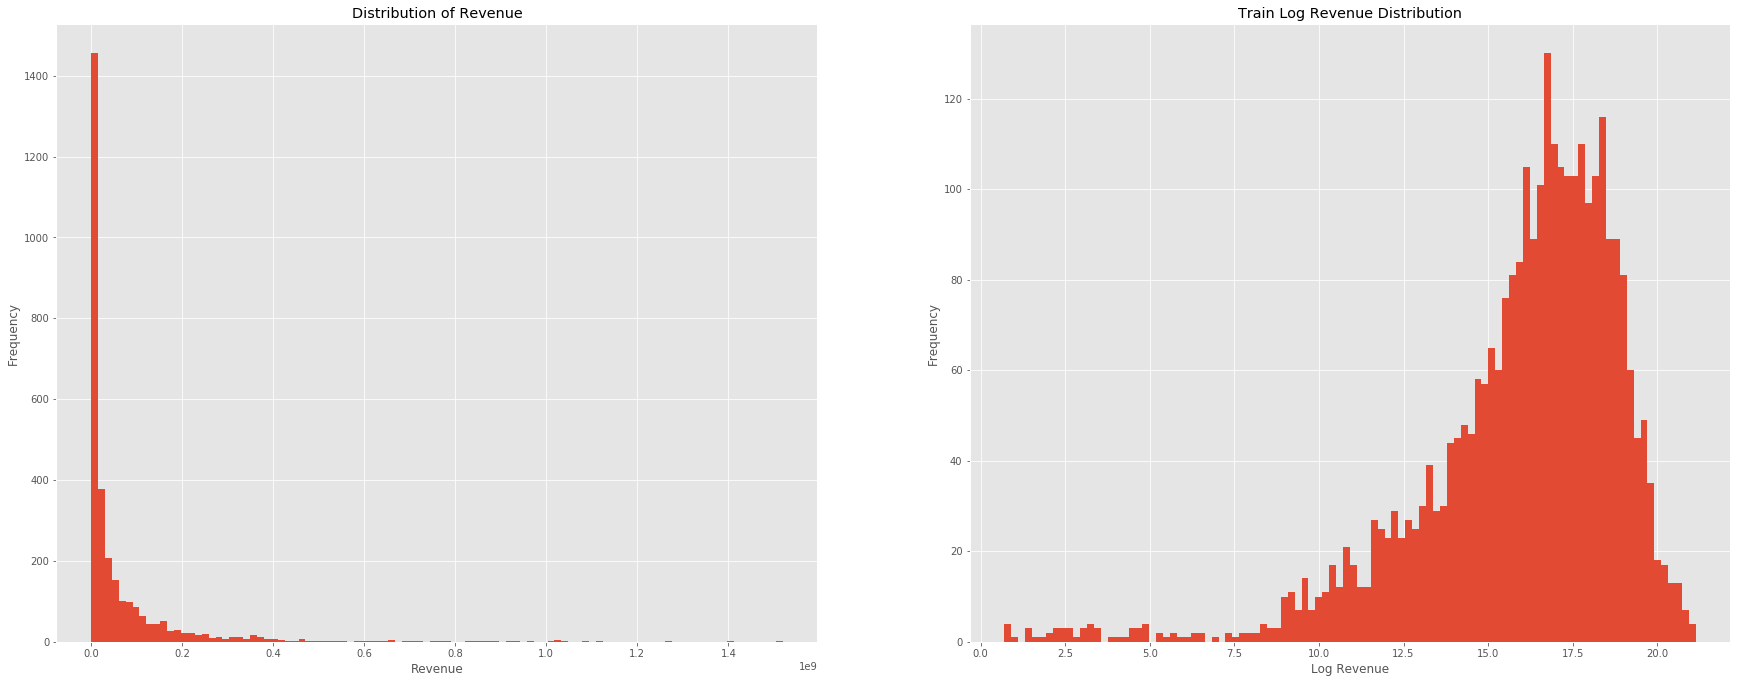

In [28]:
#### Plot the distribution of the revenue

fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['revenue'].plot(kind='hist',bins=100)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')

plt.subplot(222)
np.log1p(train['revenue']).plot(kind='hist',bins=100)
plt.title('Train Log Revenue Distribution')
plt.xlabel('Log Revenue')


print('Skew of revenue attribute: %0.1f' % skew(train['revenue']))

Skew of budget attribute: 3.1


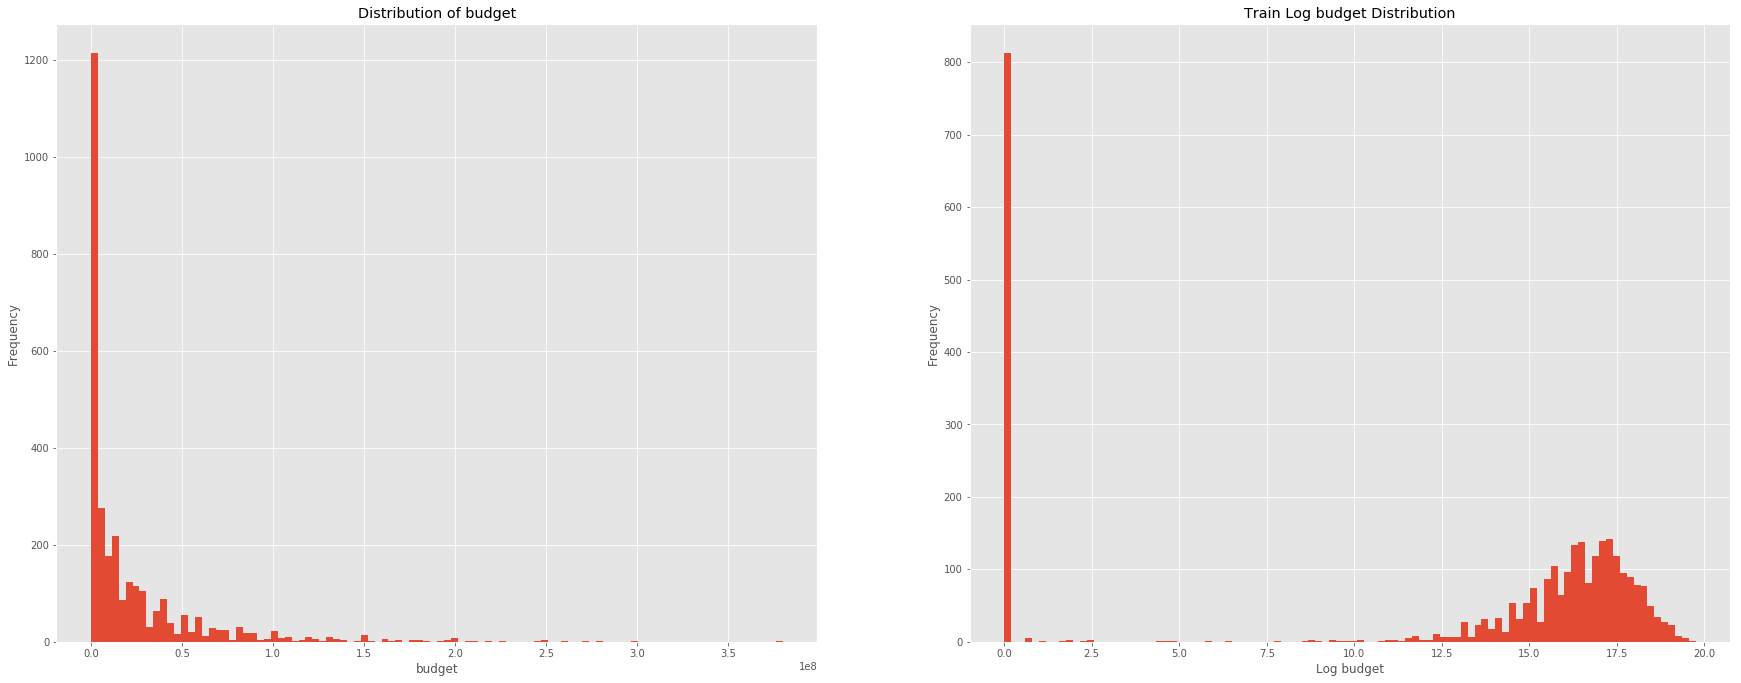

In [29]:
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['budget'].plot(kind='hist',bins=100)
plt.title('Distribution of budget')
plt.xlabel('budget')

plt.subplot(222)
np.log1p(train['budget']).plot(kind='hist',bins=100)
plt.title('Train Log budget Distribution')
plt.xlabel('Log budget')


print('Skew of budget attribute: %0.1f' % skew(train['budget']))

Skew of runtime attribute: nan


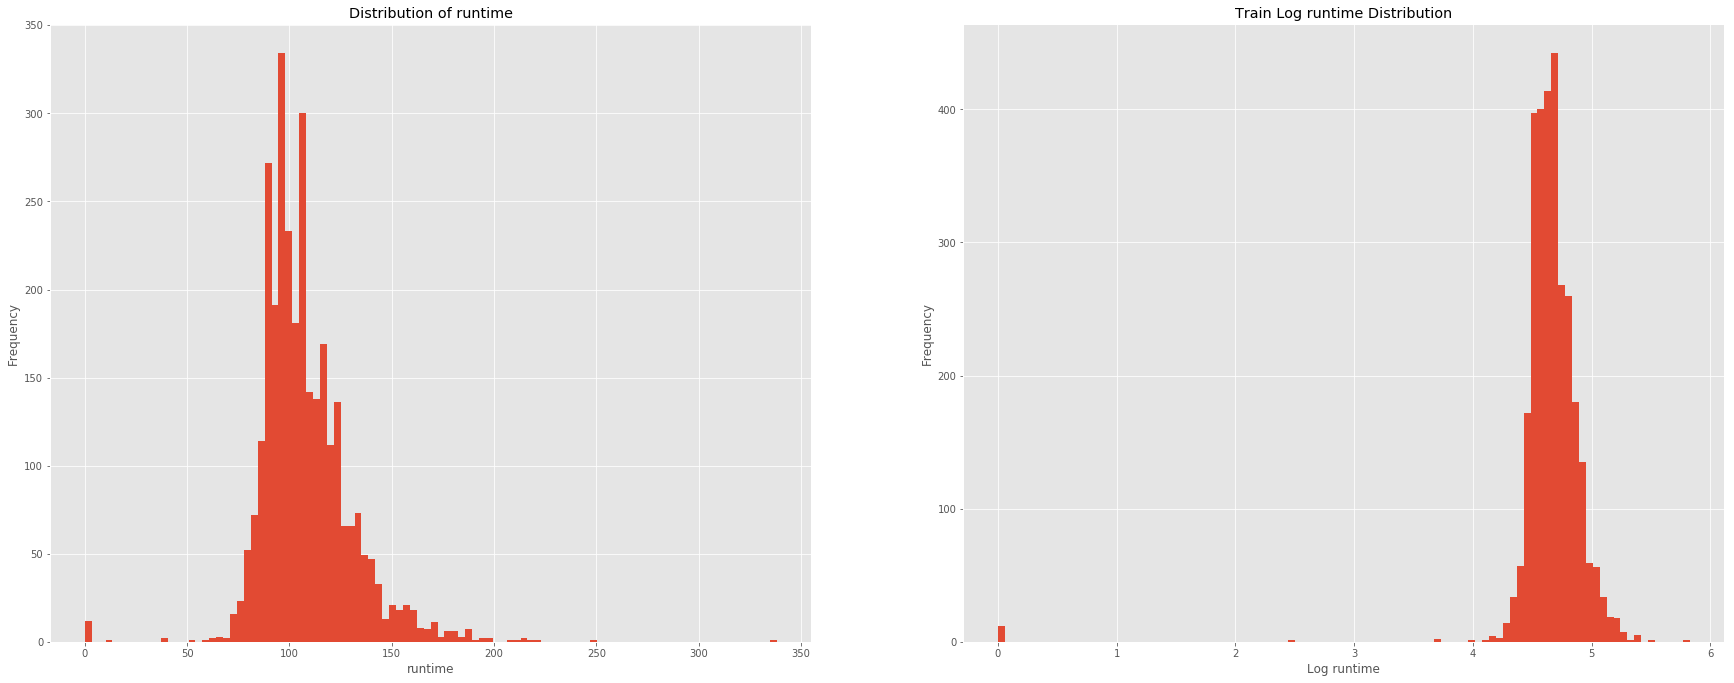

In [30]:
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['runtime'].plot(kind='hist',bins=100)
plt.title('Distribution of runtime')
plt.xlabel('runtime')

plt.subplot(222)
np.log1p(train['runtime']).plot(kind='hist',bins=100)
plt.title('Train Log runtime Distribution')
plt.xlabel('Log runtime')


print('Skew of runtime attribute: %0.1f' % skew(train['runtime']))

In [31]:
# Putting log variables for skewed data 
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])

train['log_runtime']=np.log1p(train['runtime'])
test['log_runtime']=np.log1p(test['runtime'])

train = train.drop(['budget'], axis=1)
test = test.drop(['budget'], axis=1)

# **3. Data modeling**

In [60]:
# Formating for modeling

used_features = ['release_year',
                 'num_genres', 
                 'num_production_companies', 
                 'num_production_countries',
                 'num_cast', 
                 'log_runtime',
                 'num_crew',  
                 'num_spoken_languages',
                 'num_Keywords', 
                 'has_homepage',
                 'isTaglineNA',
                 'isTitleDifferent', 
                 'log_budget', 
                 'has_collection', 
                 'isOriginalLanguageEng',
                 'isSpokenLanguageEng']

X = train[used_features]
y = np.log1p(train['revenue'])
 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
# base model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

print("훈련 점수: {:.2f}".format(xgb_model.score(X_train, y_train)))
print("테스트 점수: {:.2f}".format(xgb_model.score(X_test, y_test)))

eli5.show_weights(xgb_model, feature_filter=lambda x: x != '<BIAS>')

훈련 점수: 0.62
테스트 점수: 0.47


Weight,Feature
0.3738,log_budget
0.0852,has_collection
0.0645,isTaglineNA
0.0633,isOriginalLanguageEng
0.0584,num_production_companies
0.0562,num_Keywords
0.0443,release_year
0.0375,isSpokenLanguageEng
0.0361,num_spoken_languages
0.0353,log_runtime


In [63]:
# base model
lgb_model = lgb.LGBMRegressor(n_estimators = 100, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train)

print("훈련 점수: {:.2f}".format(lgb_model.score(X_train, y_train)))
print("테스트 점수: {:.2f}".format(lgb_model.score(X_test, y_test)))

eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

훈련 점수: 0.83
테스트 점수: 0.46


Weight,Feature
0.5022,log_budget
0.1131,release_year
0.0824,log_runtime
0.0632,num_cast
0.0583,num_crew
0.0555,num_Keywords
0.0316,num_production_companies
0.0274,has_collection
0.0135,num_genres
0.0121,num_production_countries


# 4.**성능 개선 **


## 4.1. **데이터 수집**

## 4.2. **FE**

## 4.3. **모델 튜닝**

In [ ]:
# params = {'num_leaves': 30,
#          'min_data_in_leaf': 20,
#          'objective': 'regression',
#          'max_depth': 10, # 10 
#          'learning_rate': 0.01 ,
#          "boosting": "gbdt", # gbdt
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.2,
#          "verbosity": -1}

lgb_model = lgb.LGBMRegressor(n_estimators = 10000, nthread = 4, n_jobs = -1)
# lgb_model.fit(X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
#         verbose=1000, early_stopping_rounds=200)

boosting_type = ['gbdt', 'dart', 'goss', 'rf']
max_depth = [5, 10, 15]

for depth in max_depth:
    lgb_model.set_params(max_depth = depth)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200) 
    print("훈련 점수: {:.2f}".format(lgb_model.score(X_train, y_train)))
    print("테스트 점수: {:.2f}".format(lgb_model.score(X_test, y_test)))

In [ ]:
eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

# 5. **Result**